In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import pos_tag
import re

from sklearn import tree
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from scipy.stats import ttest_rel
import itertools


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/mateus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mateus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mateus/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mateus/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/mateus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Criando data frame
data_frame = pd.read_csv("SMSSpamCollection", sep="\t" ,header = None, names=["label","message"])
display(data_frame)

count = data_frame['label'].value_counts()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
2261,spam,SplashMobile: Choose from 1000s of gr8 tones e...
2262,ham,Did you show him and wot did he say or could u...
2263,ham,It should take about &lt;#&gt; min
2264,spam,Not heard from U4 a while. Call 4 rude chat pr...


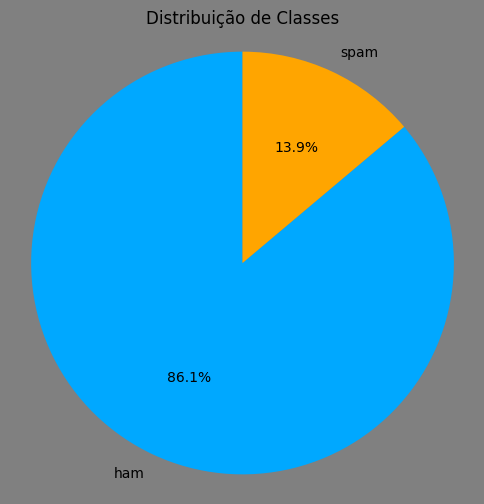

In [4]:
#plotando Distribuição de Classes
fig, ax = plt.subplots(figsize=(6,6), facecolor='grey')
colors = ['#00A8FF', '#FFA500'] 
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição de Classes')
plt.axis('equal')
plt.show()


In [5]:
#Contagem de palavras
def word_count(text):
    return len(str(text).split())
data_frame['Word_Count'] = data_frame['message'].apply(word_count)

display(data_frame)

#Calculando a soma total de palavras
total_words = data_frame['Word_Count'].sum()
print("Número total de palavras: ",total_words)

,label,message,Word_Count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
2261,spam,SplashMobile: Choose from 1000s of gr8 tones e...,28
2262,ham,Did you show him and wot did he say or could u...,17
2263,ham,It should take about &lt;#&gt; min,6
2264,spam,Not heard from U4 a while. Call 4 rude chat pr...,33


Número total de palavras:  35934


In [6]:
#Realizando o pré processamento

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+','', text)

def remove_tags(text):
    return re.sub(r'#\w+|@\w+','', text)

def remove_punctuation(text):
    text = ''.join(char for char in text if char not in string.punctuation)
    return text

def remove_numbers(text):
    return re.sub(r'\d+','',text)

def remove_repetitions(text):
    return re.sub(r'(.)\1{2,}',r'\1\1', text)

def remove_small(text):
    return [word for word in text if len(word) >= 3]

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

#não esta funcionando
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    pos_tags = pos_tag(tokens)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

def preprocces(text):
    text = text.lower()
    text = remove_urls(text)
    text = remove_tags(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_repetitions(text)
    tokens = text.split()
    tokens = remove_stopwords(tokens)
    tokens = remove_small(tokens)
    tokens = lemmatize_tokens(tokens)
    return tokens

data_frame['message'] = data_frame['message'].apply(preprocces)


data_frame['Word_Count'] = data_frame['message'].apply(word_count)
total_words = data_frame['Word_Count'].sum()
print("Número total de palavras: ",total_words)

display(data_frame['message'])


Número total de palavras:  18358


0       [jurong, point, crazy, available, bugis, great...
1                                 [lar, joking, wif, oni]
2       [free, entry, wkly, comp, win, cup, final, tkt...
3                    [dun, say, early, hor, already, say]
4       [nah, dont, think, go, usf, life, around, though]
                              ...                        
2261    [splashmobile, choose, tone, subscrition, serv...
2262                        [show, wot, say, could, dust]
2263                                    [take, ltgt, min]
2264    [heard, call, rude, chat, private, line, cum, ...
2265         [bus, come, soon, come, otherwise, tomorrow]
Name: message, Length: 2266, dtype: object

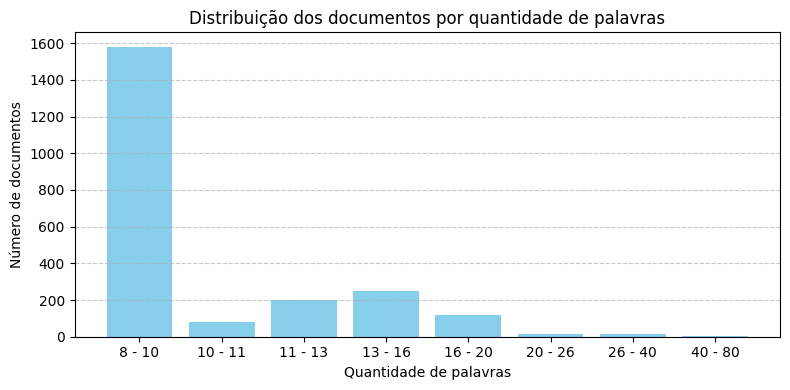

In [7]:
max_words = data_frame['Word_Count'].max()
num_bar = 8
count = np.zeros(num_bar)

for doc in data_frame['Word_Count']:
    for i in range(num_bar):
        if doc <= max_words/(num_bar-i):
            count[i]+=1
            break

labels = []
for i in range(num_bar):
    lower_bound = int(max_words / (num_bar - i + 1))  
    upper_bound = int(max_words / (num_bar - i))      
    labels.append(f"{lower_bound} - {upper_bound}")

plt.figure(figsize=(8, 4))
plt.bar(labels, count, color='skyblue')
plt.xlabel('Quantidade de palavras')
plt.ylabel('Número de documentos')
plt.title('Distribuição dos documentos por quantidade de palavras')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
#KNN Algorithm
def knn(y_train,X_test_tfidf,X_train_tfidf, y_test):
    def euclidean_distance(point1,point2):
        distance = np.sqrt(np.sum((point1 - point2) ** 2))
        return distance

    def find_neighbors(X_train, query_point, k):
        distances=[]
        for i in range(X_train.shape[0]):
            distance = euclidean_distance(X_train[i].toarray(), query_point.toarray()) #calculando a distância euclediana de cada pont de X_train com query_point
            distances.append((i,distance))
        distances.sort(key=lambda x:x[1])
        neighbors = [index for index, _ in distances[:k]] # os k pontos mais próximos serão os vizinhos
        return neighbors
        
    def predict(X_train, y_train, query_point, k):
        neighbors = find_neighbors(X_train, query_point,k) # encontra os k vizinhos
        neighbor_label = [y_train[i] for i in neighbors] # busca o label deles

        label_counts = {}
        for label in neighbor_label: # conta a ocorrência de cada label nos vizinhos
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
        
        predicted_class = max(label_counts, key=label_counts.get)
        return predicted_class #retorna o label com maior ocorrência


    #Fazendo as predições de X_test sobre os pontos de X_train
    predictions = []
    for i in range(X_test_tfidf.shape[0]):
        query_point = X_test_tfidf[i]
        pred = predict(X_train_tfidf, y_train, query_point, k=5)
        predictions.append(pred)

    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test,predictions, average='weighted')

    print("Acurácia:", accuracy)
    print("f1:",f1)

    return accuracy, f1

In [14]:
#KNN com biblioteca

def knn2(X_train_tfidf, y_train,X_test_tfidf,y_test):
    #Treinando o modelo SVM
    knn = KNeighborsClassifier()
    parameters = {'n_neighbors': [5,10,15], #quantidade de k
                'metric': ['euclidean', 'manhattan']} #método de cálculo de distância
    clf = GridSearchCV(knn,parameters,cv=5, scoring='accuracy')

    clf.fit(X_train_tfidf, y_train)
    best_knn = clf.best_estimator_

    #Avaliando o modelo
    pred_y = best_knn.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, pred_y)
    f1 = f1_score(y_test,pred_y, average='weighted')
    print("Melhores parâmetros:", clf.best_params_)
    print("Acurácia:", accuracy,"f1:",f1)

    return accuracy,f1

In [13]:
#SVM Algorithm

#Treinando o modelo SVM
def svm(X_train_tfidf, y_train,X_test_tfidf,y_test):
    #Decidindo os hiperparâmentros
    svm_model = SVC()
    parameters = {'kernel':['linear'], 
                'C':[1,10]} #tamanho da margem
    clf = GridSearchCV(svm_model,parameters,cv=5, scoring='accuracy')

    clf.fit(X_train_tfidf, y_train) #treina com todas as combinações
    best_svm = clf.best_estimator_ #escolhe a combinação de parâmetros com melhor desempenho

    #Avaliando o modelo
    y_pred = best_svm.predict(X_test_tfidf) #Aplicando o modelo no resto das entradas com o modelo ja treinado
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred, average='weighted')
    print("Melhores hiperparâmetros:", clf.best_params_)
    print("Accuracy:", accuracy, "f1:",f1)
    #O que é macro, micro e weighted?

    return accuracy,f1


In [12]:
#Decision Trees
def decision_tree(X_train_tfidf, y_train,X_test_tfidf,y_test):
    #Treinando o modelo
    tree_clf = tree.DecisionTreeClassifier(random_state=42)

    #Decidindo os hiperparâmentros
    parameters = { 
        'criterion': ['gini', 'entropy'], 
        'max_depth': [None, 5, 10, 20], #profundidade máx da árvore
        'min_samples_split': [2, 5, 10], #mínimo de amostras para dividir um nó interno
        'min_samples_leaf': [1, 2, 4] #mínimo de amostras por nó folha
    }
    clf = GridSearchCV(estimator = tree_clf, param_grid = parameters, cv = 5, scoring='accuracy')

    clf.fit(X_train_tfidf,y_train) #treina com todas as combinações
    best_tree = clf.best_estimator_ #escolhe o com melhor desempenho

    #Avaliando o modelo
    tree_pred = best_tree.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, tree_pred)
    f1 = f1_score(y_test,tree_pred, average='weighted')
    print("Melhores hiperparâmetros:", clf.best_params_)
    print("Accuracy:", accuracy, "f1:",f1)

    return accuracy,f1

#plt.figure(figsize=(20,10))
#tree.plot_tree(best_tree, max_depth=2, feature_names=vectorizer.get_feature_names_out(), class_names=label_enconder.classes_, filled=True)
#plt.show()
# max_depth profundidade da árvore
# filled=True colore os nós de acordo com a classe predominante
# feature_names mostra quais palavras sao mais importantes para as decisoes

In [15]:
#TF-IDF com kfold Holdout

import random

X = data_frame['message'].apply(lambda tokens: ' '.join(tokens)).tolist() # Dados de entrada, matriz gerada pelo TfidfVectorizer

y = data_frame["label"] # Rótulos ham ou spam
label_enconder = LabelEncoder()
y_enconder = label_enconder.fit_transform(y) #transforma o label em número: 0->ham 1->spam

vectorizer = TfidfVectorizer()

k=5
fold_size = len(X)//k


# Armazenar métricas
accuracy_scores = []
f1_scores = []
#Métodos de classificação aplicados
methods = {"KNN" : knn2, "SVM" : svm, "DECISION TREES" : decision_tree}

#Armazenando métricas
results = {name: {"accuracy": [], "f1":[]} for name in methods.keys()}


# Dividindo a base de dados em teste e treino k vezes
for fold in range(k):
    random_num = random.randint(1, k)
    test_index = []
    start = (random_num-1)*fold_size
    end = start+fold_size

    for i in range(start,end):
        test_index.append(i)

    train_index = [i for i in range(len(X)) if i not in set(test_index)]
                       
    
    X_train_fold = [X[i] for i in train_index]
    y_train_fold = [y_enconder[i] for i in train_index]
    X_test_fold = [X[i] for i in test_index]
    y_test_fold = [y_enconder[i] for i in test_index]

    X_train_tfidf = vectorizer.fit_transform(X_train_fold)
    X_test_tfidf =  vectorizer.transform(X_test_fold)

    print("_____________________________________________________")
    print(f"Fold {fold+1}:")
    for name,method in methods.items():
        print("Método:", name)
        accuracy, f1 = method(X_train_tfidf,y_train_fold,X_test_tfidf,y_test_fold)

        results[name]["accuracy"].append(accuracy)
        results[name]["f1"].append(f1)

# Resultados finais
print("_____________________________________________________")
for name in methods.keys():
    print(name)
    print(f"Acurácia média: {np.mean(results[name]['accuracy']):.4f}, desvio padrão: {np.std(results[name]['accuracy']):.4f}")
    print(f"F1-score médio: {np.mean(results[name]['f1']):.4f}, desvio padrão: {np.std(results[name]['f1']):.4f}")


_____________________________________________________
Fold 1:
Método: KNN
Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 5}
Acurácia: 0.8631346578366446 f1: 0.8222293046652391
Método: SVM
Melhores hiperparâmetros: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.9735099337748344 f1: 0.9730778149237322
Método: DECISION TREES
Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.9492273730684326 f1: 0.9482526303718357
_____________________________________________________
Fold 2:
Método: KNN
Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 15}
Acurácia: 0.9072847682119205 f1: 0.8840118928134987
Método: SVM
Melhores hiperparâmetros: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.9867549668874173 f1: 0.9866575514321806
Método: DECISION TREES
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.9337748344370861 f1: 0.932251167102369
___

KeyboardInterrupt: 

In [13]:
#TF-IDF com kfold cross-validation
X = data_frame['message'].apply(lambda tokens: ' '.join(tokens)).tolist() # Dados de entrada, matriz gerada pelo TfidfVectorizer

y = data_frame["label"] # Rótulos ham ou spam
label_enconder = LabelEncoder()
y_enconder = label_enconder.fit_transform(y) #transforma o label em número: 0->ham 1->spam

vectorizer = TfidfVectorizer()

# Configuração do kfold
skf = StratifiedKFold(n_splits=10)

# Armazenar métricas
accuracy_scores = []
f1_scores = []
#Métodos de classificação aplicados
methods = {"KNN" : knn2, "SVM" : svm, "DECISION TREES" : decision_tree}

#Armazenando métricas
results = {name: {"accuracy": [], "f1":[]} for name in methods.keys()}

# Dividindo a base de dados em teste e treino k vezes
for i,(train_index, test_index) in enumerate(skf.split(X, y_enconder)):
    X_train_fold = [X[i] for i in train_index]
    X_test_fold = [X[i] for i in test_index]
    y_train_fold = [y_enconder[i] for i in train_index]
    y_test_fold = [y_enconder[i] for i in test_index]

    X_train_tfidf = vectorizer.fit_transform(X_train_fold)
    X_test_tfidf =  vectorizer.transform(X_test_fold)

    print("_____________________________________________________")
    print(f"Fold {i+1}:")
    for name,method in methods.items():
        print("Método:", name)
        accuracy, f1 = method(X_train_tfidf,y_train_fold,X_test_tfidf,y_test_fold)

        results[name]["accuracy"].append(accuracy)
        results[name]["f1"].append(f1)

# Resultados finais
print("_____________________________________________________")
for name in methods.keys():
    print(name)
    print(f"Acurácia média: {np.mean(results[name]['accuracy']):.4f}, desvio padrão: {np.std(results[name]['accuracy']):.4f}")
    print(f"F1-score médio: {np.mean(results[name]['f1']):.4f}, desvio padrão: {np.std(results[name]['f1']):.4f}")

_____________________________________________________
Fold 1:
Método: KNN
Acurácia: 0.8854625550660793 f1: 0.8476639804022137
Método: SVM
Accuracy: 0.973568281938326 f1: 0.9731948388828014
Método: DECISION TREES
Accuracy: 0.9515418502202643 f1: 0.9524732585964933
_____________________________________________________
Fold 2:
Método: KNN
Acurácia: 0.8766519823788547 f1: 0.829973222769284
Método: SVM
Accuracy: 0.986784140969163 f1: 0.986498331359571
Método: DECISION TREES
Accuracy: 0.973568281938326 f1: 0.973568281938326
_____________________________________________________
Fold 3:
Método: KNN
Acurácia: 0.9074889867841409 f1: 0.887262508253836
Método: SVM
Accuracy: 0.986784140969163 f1: 0.9868688144579112
Método: DECISION TREES
Accuracy: 0.960352422907489 f1: 0.9606064433737334
_____________________________________________________
Fold 4:
Método: KNN
Acurácia: 0.8722466960352423 f1: 0.8237413843082889
Método: SVM
Accuracy: 0.9691629955947136 f1: 0.9680515137796337
Método: DECISION TREES
A

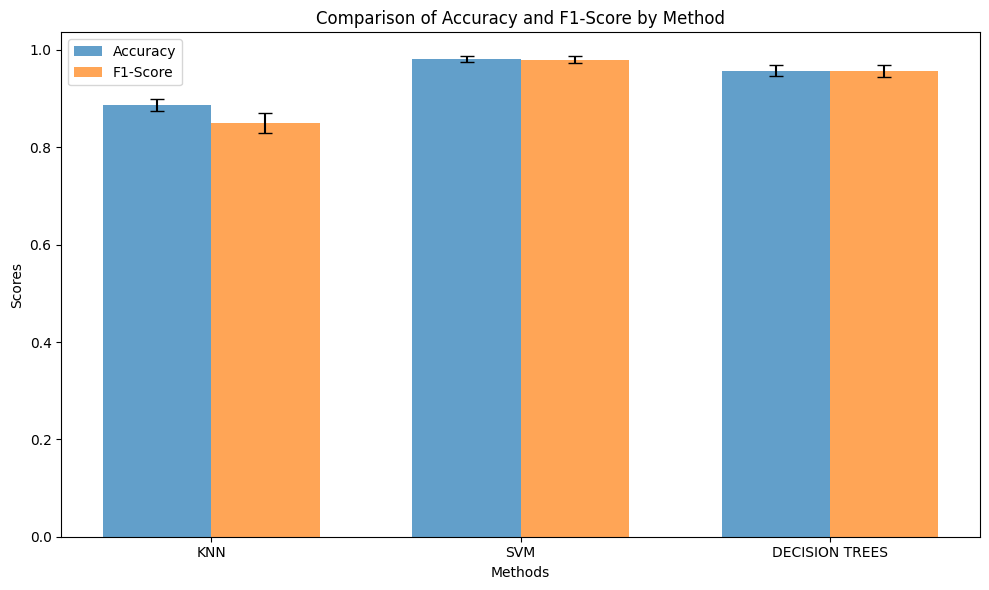

In [14]:
# Calculando médias e desvios padrão para cada método
methods = list(results.keys())
metrics = ["accuracy", "f1"]
means = {metric: [np.mean(results[method][metric]) for method in methods] for metric in metrics}
stds = {metric: [np.std(results[method][metric]) for method in methods] for metric in metrics}

# Gráfico combinado
x = np.arange(len(methods))  # Índices para os métodos
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras para cada métrica
bars1 = ax.bar(x - width/2, means["accuracy"], width, yerr=stds["accuracy"], capsize=5, label="Accuracy", alpha=0.7)
bars2 = ax.bar(x + width/2, means["f1"], width, yerr=stds["f1"], capsize=5, label="F1-Score", alpha=0.7)

# Configurações do gráfico
ax.set_xlabel('Methods')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and F1-Score by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# Ajuste do layout
plt.tight_layout()
plt.show()


In [15]:
# Aplicando teste T

testT = list(itertools.combinations(methods,2))

num_comparisons = len(testT)
alpha = 0.05
adjusted_alpha = alpha/num_comparisons

for metric in ["accuracy","f1"]:
    print(f"\nMétrica: {metric}")
    for method1, method2 in testT:
        scores1 = results[method1][metric]
        scores2 = results[method2][metric]

         # Teste T pareado
        t_stat, p_value = ttest_rel(scores1, scores2)

        # Correção de Bonferroni
        p_value_corrected = p_value * num_comparisons

        print(f"{method1} vs {method2}:")
        print(f"t = {t_stat:.4f}, p = {p_value:.4e} (corrigido: {p_value_corrected:.4e})")
        if p_value_corrected < adjusted_alpha:
            print("-> Diferença estatisticamente significativa!")
        else:
            print("-> Não há diferença estatisticamente significativa.")


Métrica: accuracy
KNN vs SVM:
t = -29.0084, p = 3.3516e-10 (corrigido: 1.0055e-09)
-> Diferença estatisticamente significativa!
KNN vs DECISION TREES:
t = -15.0132, p = 1.1195e-07 (corrigido: 3.3585e-07)
-> Diferença estatisticamente significativa!
SVM vs DECISION TREES:
t = 7.2278, p = 4.9330e-05 (corrigido: 1.4799e-04)
-> Diferença estatisticamente significativa!

Métrica: f1
KNN vs SVM:
t = -21.3968, p = 5.0019e-09 (corrigido: 1.5006e-08)
-> Diferença estatisticamente significativa!
KNN vs DECISION TREES:
t = -15.2967, p = 9.5150e-08 (corrigido: 2.8545e-07)
-> Diferença estatisticamente significativa!
SVM vs DECISION TREES:
t = 7.0401, p = 6.0514e-05 (corrigido: 1.8154e-04)
-> Diferença estatisticamente significativa!


### Word2vec

In [8]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = data_frame['message'],  vector_size=100, window=5, min_count=1, workers=4, sg=10)
model.save("word2vec.model")

In [9]:
print("Quais palavras são mais prováveis de coocorrer com free e money:")
probs = model.predict_output_word(["free","money"],topn=10)
for word, prob in probs:
    print(f"{word}: {prob:.4f}", end="| ")
print(" ")

print("Quais palavras são mais similares à free:")
similiar_free = model.wv.most_similar("free", topn=10)
for word, prob in similiar_free:
    print(f"{word}: {prob:.4f}", end=" | ")
print(" ")

Quais palavras são mais prováveis de coocorrer com free e money:
strip: 0.0004| notebook: 0.0003| £million: 0.0003| data: 0.0003| pptxnormal: 0.0003| tomorro: 0.0003| thatdont: 0.0003| jordan: 0.0003| stchoicecouk: 0.0003| deck: 0.0003|  
Quais palavras são mais similares à free:
phone: 0.9986 | mobile: 0.9985 | txt: 0.9984 | reply: 0.9983 | please: 0.9982 | offer: 0.9982 | text: 0.9981 | call: 0.9981 | per: 0.9980 | end: 0.9980 |  


/home/mateus/lab/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mateus/lab/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 145 (\x91) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mateus/lab/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


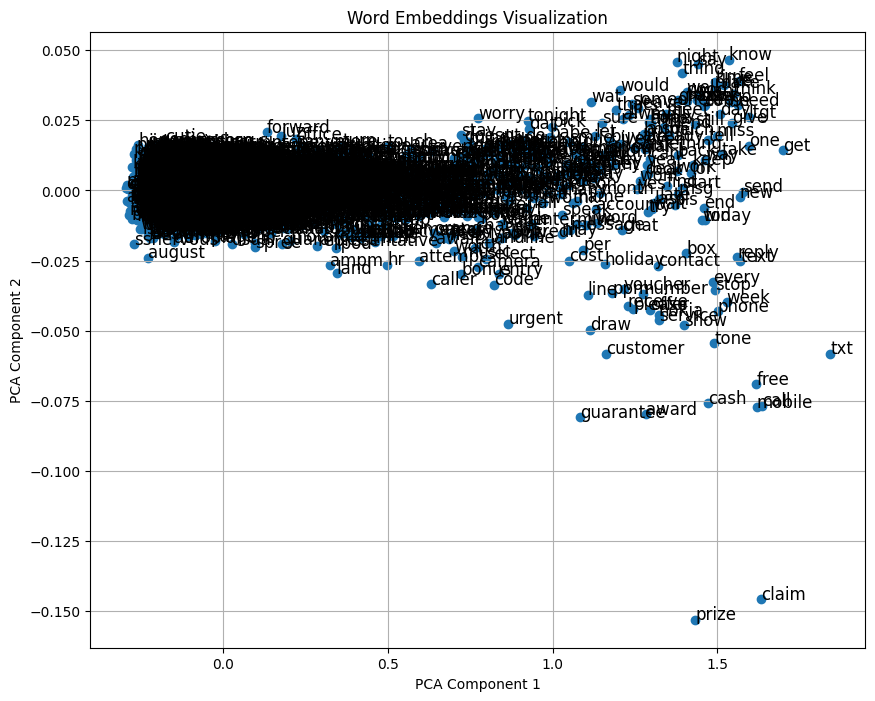

In [13]:
#Reduce dimensionality of word vectors for visuaolization

from sklearn.decomposition import PCA

word_vectors = model.wv[model.wv.index_to_key] #Get the word vectors

pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors) #Fit and transform the word vectors

#Plot the words in a 2D space
plt.figure(figsize=(10,8))
plt.scatter(result[:,0],result[:,1])

#Annotate words inn the plot
words = list(model.wv.index_to_key)
for i,word in enumerate(words):
    plt.annotate(word,xy=([result[i,0],result[i,1]]), fontsize=12)

plt.title("Word Embeddings Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()